In [1]:
import spacy

In [2]:
ua = spacy.load("/tmp/la_vectors_wiki_lg")

In [3]:
ua

In [4]:
import gzip
import json

def read_file(f):
    with gzip.open(f, 'rt', encoding='utf-8') as inf:
        j = json.load(inf)
        return j[0]['CallZText'], j[0]['CallZType']



import glob
data = []
for f in glob.glob('1551.gov.ua/raw/*/*'):
    data.append(read_file(f))

In [5]:
len(data)

127329

In [6]:
data[100]

('Знову не працює світлофор на перехресті Дегтярівська - Шамрило.\r\nДва рази на цьому тижні світлофор не працював!\r\nЦе створює дуже небезпечні умови для пересування!\r\nОкрім машин, які ідуть з 4х сторін, ще треба проіхати трамвайні коліі, на яких іздять трамваі.\r\nПрошу зясувати, в чому полягає причина частоі поламки світлофора.\r\nЗаздалегідь вдячна',
 'Робота світлофора')

In [20]:
category_types = set()
for el in data:
    category_types.add(el[1])
    
category_counts = dict() 
for t in category_types:
    category_counts[t] = 0
    
for el in data:
    category_counts[el[1]] += 1
    
s = sorted(category_counts.items(), key=lambda item: item[1])

In [53]:
top_categories = [x[0] for x in s[910:]]

In [28]:
def vec(w):
    return ua(w)[0].vector

vec('світлофор')[:5]

array([-0.983753,  0.242596,  0.855453, -0.581816, -0.171142],
      dtype=float32)

In [70]:
vec('unk')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [71]:
import sys
import tokenize_uk
def vectorize(text):
    v = vec('unk')
    words = tokenize_uk.tokenize_uk.tokenize_words(text)
    for w in words:
        v += vec(w)
    #v /= len(words)
    return v

In [72]:
X = [vectorize(a[0]) for a in data if a[1] in top_categories]

len(X)

44895

In [94]:
from sklearn import preprocessing

y_cat = [a[1] for a in data if a[1] in top_categories]
le = preprocessing.LabelEncoder()
len(y_cat)

44895

In [95]:
le.fit(y_cat) 

LabelEncoder()

In [97]:
y = le.transform(y_cat)
y[15]

2

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_train))
print(len(y_train))

30079
30079


In [100]:
import math
def check(v):
    for el in v:
        if math.isnan(el):
            return True
    return False

def check_sent(s):
    return check(vectorize(s))


            
for a in X_train:
    if check(a):
        print(a)

In [101]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [104]:
neigh.predict([X_test[10]])

array([0])

In [105]:
y_pred = neigh.predict(X_test)

In [115]:
sort_cls = [a[:20] for a in le.classes_]

In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.39      0.31       810
           1       0.59      0.80      0.68      4370
           2       0.51      0.52      0.51      1999
           3       0.48      0.51      0.49       845
           4       0.58      0.47      0.52       887
           5       0.58      0.35      0.43       731
           6       0.72      0.48      0.58      1219
           7       0.60      0.48      0.54       987
           8       0.50      0.26      0.35       745
           9       0.61      0.44      0.51      2223

    accuracy                           0.55     14816
   macro avg       0.54      0.47      0.49     14816
weighted avg       0.56      0.55      0.54     14816



In [116]:
print(classification_report(y_test, y_pred, target_names=sort_cls))

                      precision    recall  f1-score   support

Відновлення благоуст       0.26      0.39      0.31       810
     Відсутність ГВП       0.59      0.80      0.68      4370
Відсутність опалення       0.51      0.52      0.51      1999
Відсутність освітлен       0.48      0.51      0.49       845
Не працює пасажирськ       0.58      0.47      0.52       887
Незадовільна темпера       0.58      0.35      0.43       731
Перевірка дозвільної       0.72      0.48      0.58      1219
Прибирання та саніта       0.60      0.48      0.54       987
Технічний стан проїж       0.50      0.26      0.35       745
Укладання та ремонт        0.61      0.44      0.51      2223

            accuracy                           0.55     14816
           macro avg       0.54      0.47      0.49     14816
        weighted avg       0.56      0.55      0.54     14816



### Покращеня 1 - добавить косинусное расстояние в кнн

In [145]:
import sklearn
from sklearn.neighbors import DistanceMetric
from scipy import spatial
import numpy as np

def cosine_dictance(v1, v2): 
    return 1 - spatial.distance.cosine(v1, v2)

In [146]:
set(sklearn.neighbors.VALID_METRICS['ball_tree'])-set(sklearn.neighbors.VALID_METRICS['kd_tree'])

{'braycurtis',
 'canberra',
 'dice',
 'hamming',
 'haversine',
 'jaccard',
 'kulsinski',
 'mahalanobis',
 'matching',
 'pyfunc',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'wminkowski'}

#### Как можем видеть кастомная функция расстояния доступна только для Ball_Tree алгоритма

In [167]:
neigh2 = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='pyfunc', metric_params={"func":cosine_dictance})
neigh2.fit(X_train, y_train)

/Users/yehorshapanov/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='pyfunc',
                     metric_params={'func': <function cosine_dictance at 0x12db0a3b0>},
                     n_jobs=None, n_neighbors=3, p=2, weights='uniform')

In [197]:
%%time
y_pred = neigh2.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sort_cls))

/Users/yehorshapanov/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


                      precision    recall  f1-score   support

Відновлення благоуст       0.05      0.05      0.05       810
     Відсутність ГВП       0.23      0.34      0.28      4370
Відсутність опалення       0.10      0.05      0.07      1999
Відсутність освітлен       0.02      0.00      0.01       845
Не працює пасажирськ       0.00      0.00      0.00       887
Незадовільна темпера       0.08      0.00      0.01       731
Перевірка дозвільної       0.06      0.00      0.00      1219
Прибирання та саніта       0.03      0.19      0.06       987
Технічний стан проїж       0.00      0.00      0.00       745
Укладання та ремонт        0.08      0.04      0.06      2223

            accuracy                           0.13     14816
           macro avg       0.07      0.07      0.05     14816
        weighted avg       0.11      0.13      0.11     14816

CPU times: user 15min 35s, sys: 11.7 s, total: 15min 47s
Wall time: 15min 38s


#### Результат стал хуже, предположительно потому, что косинусное расстояние это не вполне метрика, т. к. в ней не выполняется неравенство треугольника а так же аксиома тождества. Ещё из-за Python object overhead involved in calling the python function использование своей функции занимает кучу времени на этапе предикта, так что категорически не рекомендутеся к использованию. 
#### К счастью есть расстояие, которое сразу встроено в объект классификатора, которое очень похоже на косинусное расстояние тем не менее является полноценной метрикой. Коеффициент Танимото:

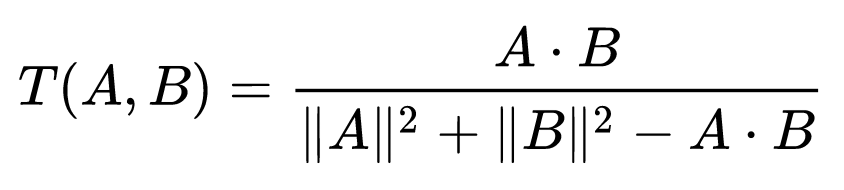

#### В пакете scipy она идёт в виде метрики Rogers-Tanimoto 

In [153]:
X = [ua('віскі')[0].vector,
    ua('вино')[0].vector]

print(DistanceMetric.get_metric('euclidean').pairwise(X))
print(DistanceMetric.get_metric('rogerstanimoto').pairwise(X))

[[ 0.         17.07055063]
 [17.07055063  0.        ]]
[[0. 0.]
 [0. 0.]]


#### Вот только она не работает :( почему не знаю 

In [159]:
print(DistanceMetric.get_metric('minkowski').pairwise(X))

[[ 0.         17.07055063]
 [17.07055063  0.        ]]


#### Тогда идея попробовать с расстоянием Минковского

In [164]:
%%time 
neigh3 = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree', metric='minkowski')
neigh3.fit(X_train, y_train)
y_pred = neigh3.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sort_cls))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 4.77 µs
                      precision    recall  f1-score   support

Відновлення благоуст       0.39      0.28      0.33       810
     Відсутність ГВП       0.58      0.88      0.70      4370
Відсутність опалення       0.55      0.50      0.53      1999
Відсутність освітлен       0.51      0.53      0.52       845
Не працює пасажирськ       0.63      0.48      0.55       887
Незадовільна темпера       0.73      0.23      0.35       731
Перевірка дозвільної       0.79      0.50      0.61      1219
Прибирання та саніта       0.59      0.51      0.55       987
Технічний стан проїж       0.56      0.26      0.35       745
Укладання та ремонт        0.59      0.53      0.56      2223

            accuracy                           0.58     14816
           macro avg       0.59      0.47      0.50     14816
        weighted avg       0.59      0.58      0.56     14816



#### точность точно такая же как и с эвклидом. это кажется неудивительным если заглянуть как они записываются. Единственное что я сделал для 3го классификатора так это увеличил количество соседей - это немного помогло

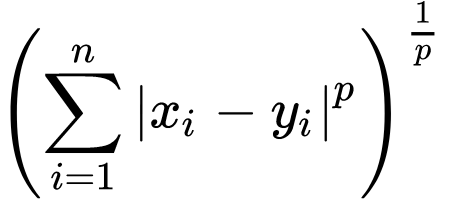
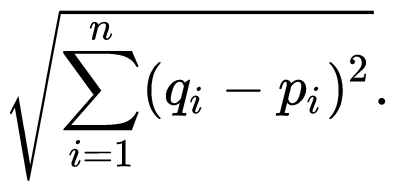

#### можно поиграться с весами во взвешенном Минковском но лучше попробовать другой классификатор

In [162]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [163]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sort_cls))

                      precision    recall  f1-score   support

Відновлення благоуст       0.54      0.50      0.52       810
     Відсутність ГВП       0.82      0.85      0.83      4370
Відсутність опалення       0.77      0.72      0.74      1999
Відсутність освітлен       0.73      0.78      0.76       845
Не працює пасажирськ       0.82      0.77      0.79       887
Незадовільна темпера       0.58      0.63      0.60       731
Перевірка дозвільної       0.83      0.82      0.83      1219
Прибирання та саніта       0.69      0.70      0.70       987
Технічний стан проїж       0.49      0.47      0.48       745
Укладання та ремонт        0.68      0.69      0.68      2223

            accuracy                           0.74     14816
           macro avg       0.70      0.69      0.69     14816
        weighted avg       0.74      0.74      0.74     14816



#### Воу! Тут уже не стыдно Кличко в глаза взглянуть. Интересно что будет если их стакнуть вместе

In [165]:
estimators = [
    ('knn', neigh3),
    ('mlp', clf)
]

sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

In [166]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sort_cls))

                      precision    recall  f1-score   support

Відновлення благоуст       0.54      0.50      0.52       810
     Відсутність ГВП       0.82      0.85      0.83      4370
Відсутність опалення       0.77      0.72      0.74      1999
Відсутність освітлен       0.73      0.78      0.76       845
Не працює пасажирськ       0.82      0.77      0.79       887
Незадовільна темпера       0.58      0.63      0.60       731
Перевірка дозвільної       0.83      0.82      0.83      1219
Прибирання та саніта       0.69      0.70      0.70       987
Технічний стан проїж       0.49      0.47      0.48       745
Укладання та ремонт        0.68      0.69      0.68      2223

            accuracy                           0.74     14816
           macro avg       0.70      0.69      0.69     14816
        weighted avg       0.74      0.74      0.74     14816



#### Никакой разницы. Очевидно сетки - это путь к успех так что дальше буду использоваться MLP и твикать ДАННЫЕ

#### лематизируем входные векторы

In [170]:
import pymorphy2  
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [201]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(ua.vocab)

In [212]:
def clean(doc):
    return [tok.text for tok in doc if (not tok.is_punct)]

clean(ua(D[1000]))

['Відсутнє', 'опалення', 'Відсутня', 'горяча', 'вода']

In [230]:
%%time
D = [a for a in data if a[1] in top_categories]
lemma_X, y_cat = [], []
for obj in D:
    sent = obj[0]
    if len(sent)>0:
        lemma_X.append([morph.parse(a)[0].normal_form for a in clean(ua(sent))])
        y_cat.append(obj[1])

CPU times: user 4min 3s, sys: 307 ms, total: 4min 3s
Wall time: 4min 3s


In [231]:
lemma_X[10][:10]

['добрий',
 'день',
 'стан',
 'на',
 '15',
 'жовтень',
 'в',
 'будинок',
 'відсутній',
 'опалення']

In [233]:
%%time
Lemma_X = [vectorize(a) for a in lemma_X]
le.fit(y_cat) 
y = le.transform(y_cat)

CPU times: user 2min 16s, sys: 694 ms, total: 2min 16s
Wall time: 2min 16s


In [234]:
X_train, X_test, y_train, y_test = train_test_split(Lemma_X, y, test_size=0.33, random_state=42)
print(len(X_train))
print(len(y_train))

30034
30034


In [235]:
clf2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [236]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sort_cls))

                      precision    recall  f1-score   support

Відновлення благоуст       0.49      0.31      0.38       795
     Відсутність ГВП       0.77      0.80      0.79      4357
Відсутність опалення       0.72      0.63      0.67      1991
Відсутність освітлен       0.55      0.68      0.61       896
Не працює пасажирськ       0.73      0.72      0.73       919
Незадовільна темпера       0.54      0.47      0.50       766
Перевірка дозвільної       0.79      0.67      0.72      1187
Прибирання та саніта       0.53      0.73      0.62      1027
Технічний стан проїж       0.39      0.41      0.40       730
Укладання та ремонт        0.61      0.62      0.61      2125

            accuracy                           0.66     14793
           macro avg       0.61      0.60      0.60     14793
        weighted avg       0.66      0.66      0.66     14793



#### попытка с tf-idf

In [239]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
Tfidf_X = vectorizer.fit_transform([" ".join(a) for a in lemma_X])

CPU times: user 1.79 s, sys: 64.6 ms, total: 1.85 s
Wall time: 1.87 s


In [240]:
Tfidf_X[5]

<1x76054 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [242]:
X_train, X_test, y_train, y_test = train_test_split(Tfidf_X, y, test_size=0.33, random_state=42)

In [246]:
print(X_train.shape)
print(y_train.shape)

(30034, 76054)
(30034,)


In [247]:
%%time
clf2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=sort_cls))

ValueError: dimension mismatch

#### Удивительно но стало хуже. Это наталкивает меня на мысль что с векторами документов должно получиться. 

#### Я попробовал запустить ELMo и оно просто тренилось так много времени и так сильно нагружало мой компьютер что я решил оставить эту затею. Плюс мне кажется, что от того что в Уберкорпусе все предложения перемешаны качество выйдет нулевое. 

## Визуализация

In [249]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [271]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [273]:
%%time
digits_proj = TSNE(random_state=RS, perplexity=50, n_iter=2500).fit_transform(X_train)

CPU times: user 1h 10s, sys: 5min 14s, total: 1h 5min 25s
Wall time: 4min 47s


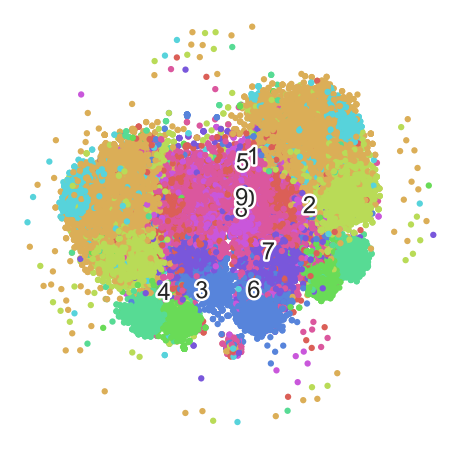

In [274]:
scatter(digits_proj, y_train)
plt.savefig('images/digits_tsne-generated.png', dpi=120)